In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import CHILDES_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
transcript_df = pd.read_pickle(CHILDES_DFS/'childes_df_subset.pickle')
#transcript_df['dataset'] = [i[0].split('/')[11] for i in transcript_df.transcript_xml.values]
len(transcript_df)

2785

In [5]:
# mask for only a subset of corpuses
possible_corpuses = [
    # carterette is also transcribed in IPA
    "Carterette",  # 1st, 3rd, 5th grade, adults, speech naturalistic speech in IPA https://childes.talkbank.org/access/Eng-NA/Carterette.html
    "Gillam",  # normal subset, spontaneous storytelling 5-11y11m https://childes.talkbank.org/access/Clinical-MOR/Gillam.html
    "Braunwald",  # single subject from 1-6yo talking to family https://childes.talkbank.org/access/Eng-NA/Braunwald.html
    "Brown",  # 1y6m-5y1m, 3 subjects naturalistic talking to parents https://childes.talkbank.org/access/Eng-NA/Brown.html
    "EllisWeismer",  # 2y6m - 5y6 naturalistic play-oriented talk with instructor # https://childes.talkbank.org/access/Clinical-MOR/EllisWeismer.html
    "Gleason",  # 2;1 - 5;2 family interactions https://childes.talkbank.org/access/Eng-NA/Gleason.html
    "NH",# Nicholas-NH,  # 1;0-4;0, videotaped play with parent https://childes.talkbank.org/access/Clinical-MOR/Nicholas/NH.html
    "Post",  # 1;7-2;8 60m session with family and toys https://childes.talkbank.org/access/Eng-NA/Post.html
    "Normal",  #  Rondal-Normal 3-12yo free play with mother and child https://childes.talkbank.org/access/Clinical-MOR/Normal /Normal.html
]
corpus_mask = [corpus in possible_corpuses for corpus in transcript_df.corpus.values]
transcript_df = transcript_df[corpus_mask]

In [6]:
# mask for a subset of roles
possible_roles = ['Target_Child', 'Child']
role_mask = [role in possible_roles for role in transcript_df.role.values]
transcript_df = transcript_df[role_mask]
len(transcript_df)

2785

In [7]:
transcript_df[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS,age_months,age_years
72301,11312/c-00015848-1,eng,Carterette,1984-01-01,CHI,Target_Child,P6Y,eng,NaN,"[[pro:per, v, , , conj, n:prop, coord, pro:ind...","[[you, mean, uh, um, like, England, or, someth...","[[you, mean, uh, um, like, England, or, someth...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,19903,2102,2102,72.0,6.0
72302,11312/c-00015847-1,eng,Carterette,1984-01-01,CHI,Target_Child,P10Y,eng,NaN,"[[co, , pro:sub, v, , det:num, n], [coord, , p...","[[well, um, I, have, uh, one, sister], [and, u...","[[well, um, I, have, uh, one, sister], [and, u...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,26941,2729,2729,120.0,10.0
72303,11312/c-00015849-1,eng,Carterette,1984-01-01,CHI,Target_Child,P8Y,eng,NaN,"[[v, n, n], [co, n:prop, v, prep, det:art, n, ...","[[lets, watch, tv], [well, Nancy, said, for, t...","[[let-3S, watch, tv], [well, Nancy, say-PAST, ...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,21419,2019,2019,96.0,8.0


In [8]:
print(transcript_df.corpus.unique())

['Carterette' 'Brown' 'Braunwald' 'Post' 'Gleason' 'Normal' 'Gillam'
 'EllisWeismer' 'NH']


In [9]:
print("there are {} words in this dataset".format(np.sum(transcript_df.n_words.values)))

there are 1247296 words in this dataset


### Get child ages

In [11]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

In [12]:
def quickplot_decay(distances, MI, shuff_MI, title=''):
    fig,axs = plt.subplots(ncols=2, figsize = (10,4))
    ax = axs[0]
    ax.set_title(title)
    ax.scatter(distances, MI-shuff_MI)
    ax.plot(distances, MI-shuff_MI, alpha = 0)
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax = axs[1]
    ax.scatter(distances, MI)
    ax.scatter(distances, shuff_MI)
    plt.show()

In [13]:
row = transcript_df.sort_values(by='n_words', ascending=False).iloc[0]

In [14]:
words_list = list(flatten([i for i in flatten(row.words) if i is not None]))
words_list[:10]

['well', 'um', 'I', 'have', 'uh', 'one', 'sister', 'and', 'um', "she's"]

In [15]:
n_words = len(words_list)
n_unique_words = len(np.unique(words_list))
n_words, n_unique_words

(26941, 2662)

In [16]:
distances = np.arange(1, n_words - 1)

In [17]:
from childes_mi.information_theory import mutual_information as mi

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.expected_mutual_info_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [28]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information([list(words_list)],  
                                                                          distances = distances, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 998 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1466 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 2006 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2618 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 3302 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 4058 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 4886 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 5786 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 6758 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 7802 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 8918 tasks      | 

[Parallel(n_jobs=-1)]: Done 26939 out of 26939 | elapsed:   38.5s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 4160 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 6752 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 8264 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 9920 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 11720 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 13664 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 15752 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 17984 tasks  

[Parallel(n_jobs=-1)]: Done 26939 out of 26939 | elapsed:   36.2s finished


In [19]:
shuffled_words = np.random.permutation(list(words_list))

In [20]:
shuffled_words[:10]

array(['you', 'do', 'in', 'three', 'father', "won't", 'certain', 'smart',
       'tortoise', 'club'], dtype='<U28')

In [31]:
(MI_seqshuff, MI_var_seqshuff), (shuff_MI_seqshuff, shuff_MI_var_seqshuff) = mi.sequential_mutual_information([shuffled_words],  
                                                                          distances = distances, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 4160 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 6752 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 8264 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 9920 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 11720 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 13664 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 15752 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 17984 tasks  

[Parallel(n_jobs=-1)]: Done 26939 out of 26939 | elapsed:   36.2s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 4160 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 6752 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 8264 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 9920 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 11720 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 13664 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 15752 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 17984 tasks  

[Parallel(n_jobs=-1)]: Done 26939 out of 26939 | elapsed:   36.9s finished


In [21]:
(MI_seqshuff, MI_var_seqshuff), (shuff_MI_seqshuff, shuff_MI_var_seqshuff) = mi.sequential_mutual_information([words_list],  
                                                                          distances = distances, n_jobs=-1, mi_estimation= 'adjusted_mi_sklearn')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.5min


KeyboardInterrupt: 

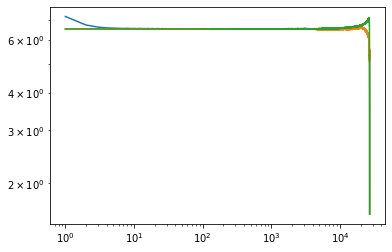

In [38]:
fig, ax = plt.subplots()

ax.plot(distances, MI)
ax.plot(distances, shuff_MI)
ax.plot(distances, MI_seqshuff)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([])

In [65]:
np.log2(n_words)

14.717515781510224

In [75]:
mask_nums = np.unique((np.logspace(0, 14.7, num=100, base=2).astype('int')))
mask = np.isin(distances, mask_nums)

[None, None, None, None]

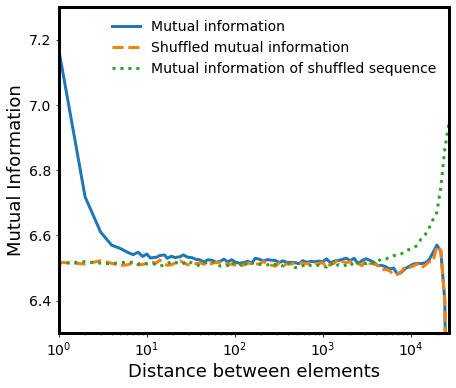

In [101]:
fig, ax = plt.subplots(figsize=(7,6))
s = 10
lw = 3

ax.plot(distances[mask], MI[mask], lw=lw, label="Mutual information")
ax.plot(distances[mask], shuff_MI[mask], lw=lw, ls='dashed', label="Shuffled mutual information")
ax.plot(distances[mask], MI_seqshuff[mask], lw=lw, ls='dotted',  label="Mutual information of shuffled sequence")

ax.set_ylabel("Mutual Information", fontsize=18)
ax.set_xlabel("Distance between elements", fontsize=18)
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([6.3,7.3])
ax.set_xlim([1, n_words-1])
ax.legend(fontsize=14, frameon=False)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(3) for i in ax.spines.values()]